Assignment 2 part II
====================

Aim:
- Implementing two implicit solvers, the backward Euler and Crank-Nicholson method.
- Study the convergence order and comparing the method using a non-linear 2x2 ODE system.
- Study a Hamiltonian flow
- Implement two split methods for the Hamiltonian flow

Initial imports including the methods from the quizzes
('newton', 'evolve', 'computeEocs', 'backward/forwardEuler')

In [1]:
from IPython.display import display, HTML, display_html, Latex
import pandas as pd
import numpy as np
from numpy import array, exp, zeros, sqrt, cos, sin, pi
from numpy.linalg import norm, inv, expm
from scipy.special import ellipj, ellipk
from matplotlib import pyplot as plt

from newton import newton
from forwardEuler import forwardEuler
from backwardEuler import backwardEuler
from evolve import evolve
from computeEocs import computeEocs

Problem setup for ODE
$y'(t)=f(t,y(t))$ and $y(0)=y_0$ with right hand side
$$ f(t,y_1,y_2) = \left(\begin{array}{cc} y_2 \\[1ex] y_2(\lambda-2y_1) \end{array}\right) $$
With $\lambda=1$ and initial conditions $y_0=(2, -2)^T$ this has the exact solution
$$ Y(t) = \left(\begin{array}{cc}
     \frac{2e^t}{2e^t-1} \\[2ex]
     \frac{-2e^{t}}{4e^{2t}-4e^t+1}
\end{array}\right) $$
We will solve this on the interval $[0,T]$ with $T=10$.

In [2]:
T = 10
Y = lambda t: array([ 2*exp(t)/(2*exp(t)-1),
                      (-2*exp(t))/(4*exp(2*t)-4*exp(t)+1) ])
def f(t,y):
    return array([y[1], y[1]*(1-2*y[0])])
def Df(t,y):
    return array([[0,1],[-2*y[1],1-2*y[0]]])

We reuse the 'experiment' function from the first assignment:
The method returns an array of length $M+1$ each entry of the form '[h,max-error,eoc]'.

__Addition__: since implicit method require Newton methods which can fail to converge this function now includes a mechanism to catch this problem. An error message is produced and the returned error set to Not A Number (nan). I use _assert_ in the implicit methods to determin if the Newton method has reached the maximum number of iterations.

In [3]:
def experiment(stepper, f,Df,T,Y, M,N0):
    herr = zeros( [M,2] )
    for m in range(M):
        N = N0*2**m
        try:
            t,y = evolve( stepper, f,Df, 0,Y(0),T, N)
            herr[m] = [T/N, max( norm(Y(t).transpose()-y,axis=1) )]
        except ValueError: # method not stable for given 'h'
            print("Error:", stepper,N,T/N,"failed: some NaN value produced!")
            herr[m] = [T/N, np.nan]
        except AssertionError: # assert in dirk was triggered (failed Newton)
            print("Error:", stepper,N,T/N,"failed: Newton function failed!")
            herr[m] = [T/N, np.nan]

    eoc = computeEocs( herr )
    eoc = np.hstack( [ [np.nan],eoc ] )
    res = np.hstack( [herr, np.atleast_2d(eoc).T] )
    return res

Generate a table (using pandas) containing the computed results.
We write a method that compares an arbitrary number of different method - this is again taken from the first assignment.

In [4]:
def compareErrors(results):
    # columns of table
    simul = list(results.keys())
    columns=['h'] + [s for n in simul for s in [f'{n}-error', f'{n}-eoc']]
    # values in tablea
    keys   = {columns[0]: results[simul[0]][:,0]} # all results are assumed to use the same sequence of h
    styles = {columns[0]: '{:.4e}'}
    for i, k in enumerate(simul):
        keys[columns[2*i+1]]   = results[k][:,1] # errors
        styles[columns[2*i+1]] = '{:.6e}'
        keys[columns[2*i+2]]   = results[k][:,2] # eocs
        styles[columns[2*i+2]] = '{:.3f}'

    # generate table
    table = pd.DataFrame(keys, index=range(results[simul[0]].shape[0]), # all results must have the same shape
            columns=columns)

    # format floating points for each column for jupyter output (does not work in pdf)
    display( table.style.format(styles) )

    for i,k in enumerate(simul):
        plt.loglog(results[k][:,0],results[k][:,1],marker='o',label=k)
    plt.legend()
    plt.grid(True)
    plt.ylim([None, 10]) # Added in case some method really messes up so that one can still see the good ones
    plt.xlabel("step size h")
    plt.ylabel("Maximum error over time")
    plt.savefig("Q2_compareErr.pdf", format="pdf", bbox_inches="tight") # output to pdf for inclusing in tex document
    plt.show()

Define the methods not available through the quizzes - copied over Q11 and add Crank-Nicholson

In [5]:
def Q11( f,Df, t0,y0, h):
    f0 = f(t0,y0)
    f1 = f(t0+h, y0+h*f0)
    return y0 + h/2*(f0+f1)
def crankNicholson( f,Df, t0,y0, h):
    # rewrite as F(y) = y-h/2f(t0+h,y) - ( y0+h/2f(t0,y0) )
    F  = lambda y: y-h/2*f(t0+h,y) - (y0+h/2*f(t0,y0))
    DF = lambda y: np.eye(len(y0))-h/2*Df(t0+h,y)
    # compute F(y)=0
    y,n = newton(F,DF,y0,h*h*1e-5,1000)
    assert n<1000
    return y

Summary Q2.1
------------


Error: <function backwardEuler at 0x7f3014ea23a0> 25 0.4 failed: Newton function failed!


,h,FE-error,FE-eoc,BE-error,BE-eoc,Q11-error,Q11-eoc,CN-error,CN-eoc
0,4.0000e-01,1.197520e+00,nan,nan,nan,2.336009e-01,nan,1.853749e-01,nan
1,2.0000e-01,3.849013e-01,1.637,1.949451e-01,nan,5.724377e-02,2.029,4.250296e-02,2.125
2,1.0000e-01,1.424462e-01,1.434,1.058020e-01,0.882,1.252991e-02,2.192,1.013321e-02,2.068
3,5.0000e-02,6.525497e-02,1.126,5.635231e-02,0.909,2.894328e-03,2.114,2.522720e-03,2.006
4,2.5000e-02,3.135656e-02,1.057,2.914622e-02,0.951,6.889803e-04,2.071,6.287615e-04,2.004
5,1.2500e-02,1.538350e-02,1.027,1.483127e-02,0.975,1.680073e-04,2.036,1.571657e-04,2.000
6,6.2500e-03,7.620535e-03,1.013,7.482302e-03,0.987,4.148271e-05,2.018,3.928423e-05,2.000
7,3.1250e-03,3.792678e-03,1.007,3.758094e-03,0.993,1.030578e-05,2.009,9.820607e-06,2.000
8,1.5625e-03,1.891968e-03,1.003,1.883324e-03,0.997,2.568356e-06,2.005,2.455153e-06,2.000
9,7.8125e-04,9.448989e-04,1.002,9.427381e-04,0.998,6.410798e-07,2.002,6.137865e-07,2.000


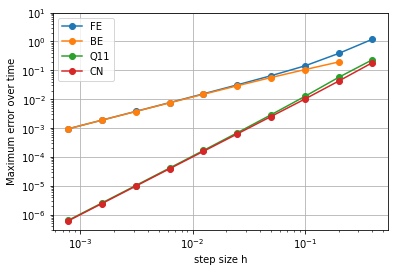

In [6]:
res = {}
res["FE"]        = experiment(forwardEuler,       f,Df,T,Y, M=10,N0=25)
res["BE"]        = experiment(backwardEuler,      f,Df,T,Y, M=10,N0=25)
res["Q11"]       = experiment(Q11,                f,Df,T,Y, M=10,N0=25)
res["CN"]        = experiment(crankNicholson,     f,Df,T,Y, M=10,N0=25)
compareErrors(res)

Summary
-------
One can clearly see the expected orders of the four methods - the two Euler methods being first order has shown in the lecture, Q11 is second order as we already know from the first assignment and the Crank-Nicholson method is also second order as expected from theory (this can seen bey cehcking the order conditions for example). 

For this example there is very little difference between the two first and the two second order methods with respect to their error for a fixed grid size.I would expect the implicit methods to be quite a bit slower due to the extra work of the Newton method. 

Finally the second order method (on a fixed grid) are much more efficient, reaching for example an error of $10^{-3}$ with more than a factor of 10 less time steps.

The backward Euler method on the coarsest grid showed problems with the Newton method not converging to the required tolerance. Looking at the iterates from the Newton method the problem with $N=25$ is that while the first component of $F(x_k)=0$ the second component stays around $1$. Reducing $N$ to example 30 solves the problem. This is not unexpected from the Newton method 

Q2.2-Q2.4: Hamiltonians
=======================
We study a different problem - the harmonic oscillator and the Duffing equation. We use the same methods as before except the Forward Euler method which suffers from stability issues...

We add two new method: first the Semi-Implicit Euler method implemented for $H(x,p)=p^2/2 + V(x)$

In [7]:
def semiImplicitEuler(dV, t0,y0, h):
    xnew  = y0[0] + h*y0[1]
    pnew  = y0[1] - h*dV(xnew)
    return array([xnew,pnew])

The second method is a fully implicit split method again implemented and optimized for a Hamiltonian of the form $H(x,p)=p^2/2 + V(x)$:

In the first step we need Newton's method to compute $x_{n+1}$
\begin{align*}
x_{n+1} = x_n + hp_n + \frac{h^2}{2}\frac{V(x)-V(x_n)}{x-x_n}
\end{align*}
The second step is explicit
\begin{align*}
p_{n+1} = p_n - h\frac{V(x_{n+1}-V(x)}{x_{n+1}-x_n}
\end{align*}

The formula for $x_{n+1}$ follows directly from $x_{n+1} = x_n + \frac{h}{2}(p_{n+1}-p_n)$ and from the second equation $p_{n+1}+p_n = 2p_n - h\frac{V(x_{n+1}-V(x_n)}{x_{n+1}-x_n}$.
A main issue is the initial guess for the Newton method since 
$F(x)=x-x_n-hp_n+h^2/2\frac{V(x)-V(x_n)}{x-x_n}$ will not be directly computable at $x=x_n$ so that is not a suitable initial guess. I would like to use $x_0=x_n+hp_n$ as initial guess (one Forward Euler step for $x'=H_p(x,p)$. But we could have $p_n=0$. So we can either do a higher order Taylor expansion for $x$:
$x_0 = x_n + hx'_n + h^2/2 x''_n = x_n + hp_n - h^2/2 V'(x_n)$ (see Taylor's method). Something similar would be to do one step of the semi-implicit method but first do a step in $p$ and then in $x$:
$p_0 = p_n - hV'(x_n), x_0 = x_n + hp_0 = x_n + hp_n - h^2V'(x_n)$. Finally we could explicitly compute what the first step of the Newton method would look like if the initial guess was $x_n$. Note that
$F(x_n)=-hp_n + h^2/2 V'(x_n)$ and use L'Hopital to explicitly compute $DF(x_n)$. Then use
$x_0 = x_n - F(x_n)/DF(x_n)$.

In [8]:
def fullyImplicit( V,dV, t0,y0, h):
    x = y0[0]
    p = y0[1]
    F  = lambda xnew: array([xnew[0] - x - h*p + h**2/2 * (V(xnew[0]) - V(x)) / (xnew[0] - x)])
    DF = lambda xnew: array([[1                + h**2/2 * (dV(xnew[0])*(xnew[0]-x) - (V(xnew[0])-V(x)))/(xnew[0]-x)**2]])
    x0 = x+h*p-h**2/2*dV(x)
    xnew,n = newton(F,DF,array([x0]),1e-5*h*h,1000)
    assert n < 1000
    pnew = p - h * ( V(xnew[0]) - V(x) ) / (xnew[0] - x)
    return array([xnew[0],pnew])

Extra: Exponentially Fit Backward Euler method (for third assignment)
---------------------------------------------------------------------
Implementation of an exponentially fit stepper (for third assignment) - based on the forward Euler method but using the formulation from a one stage Runge-Kutta method
(with $\alpha_1=\beta_{11}=\gamma_1=1$):
$$ k_1 = f(t_0+h,y_0+hk)~,\qquad y_1 = y_0 + hk_1 $$

Due to the more complex dependency of $h$ and on $M$ of these steppers, I'm defining a function that returns the stpper but first computes the required matrix exponentials depending on the parameters $h,M$. This is not the best way of doing this. Having a _class_ with a _initialize_ method would be better but beyond what I want to show in the module - so I'll go with this.

In [9]:
def expfitBackwardEuler(M,h):
    alpha, beta, gamma = 1,1,1
    exphMs    = expm(alpha*h*M)
    exphMsInv = inv(exphMs)
    exphM     = expm(h*M)
    def stepper(f,Df,t0,y0,h):
        # the actual ODE has right hand side f(t,y)-My
        fM  = lambda t,y: f(t,y) - M.dot(y)
        DfM = lambda t,y: Df(t,y) - M
        # explicit step - can be used as initial guess for Newton if beta_ii not equal to zero
        # if beta_ii = 0 then this is already the full stage
        k1 = exphMsInv.dot( fM( t0+alpha*h, exphMs.dot(y0) ) )
        F  = lambda k: k - exphMsInv.dot( fM(t0+alpha*h, exphMs.dot(y0 + h*beta*k)) )
        DF = lambda k: ( np.eye(len(y0)) - 
                         h*beta*DfM(t0+alpha*h,exphMs.dot(y0 + h*beta*k) ) )
        k1,n = newton(F,DF, k1, h*h*1e-5,1000)
        assert n < 1000
        return exphM.dot( y0 + h*k1 )
    return stepper

_Experiment_ function for the Hamiltonian:
===================================================
Finally we write an _experiment_ type function for the Hamiltonian of the form
$H(x,p)=p^2/2 + V(x)$ with $V(x)=(k^2+1)/2x^2 - k^2/2x^r$ for fixed constants $k,r$. We fix $k=0.8$ but keep $r$ as a parameter:

In [10]:
def testHamiltonian(r):
    y0 = np.array([0,1])
    k = 0.8
    if r == 2:
        def Y(t):
            return array( [sin(t), cos(t)] )
    elif r == 4:
        def Y(t):
            sn, cn, dn, _ = ellipj (t, k*k)
            return array ([ sn , cn * dn ])
    # define the Hamiltonian H(x,p) = p^2/2 + V(x)
    V   = lambda x: (k*k+1)/2*x**2 - k*k/2*x**r
    dV  = lambda x: (k*k+1)*x      - k*k/2*r*x**(r-1)
    d2V = lambda x: (k*k+1)        - k*k/2*r*(r-1)*x**(r-2)
    # the Hamiltonian
    H  = lambda y: 0.5*y[1]**2 + V(y[0])
    # and the resulting flow
    f   = lambda t,y: array(  [y[1], -dV(y[0])] )
    Df  = lambda t,y: array([ [0,          1],
                              [-d2V(y[0]), 0] ])
    # define 'M' for the exponentially fit methods:
    M = array([ [0,1], [-1, 0] ])
    # split steppers based on 'V'
    siStepper = lambda f,Df,t0,y0,h: semiImplicitEuler(dV,t0,y0,h)
    fiStepper = lambda f,Df,t0,y0,h: fullyImplicit(V,dV,t0,y0,h)

    def HamiltonianExperiment(stepper, f,Df,T,y0, H, N, name, ax1=None, ax2=None):
        try:
            t,y  = evolve(stepper,     f,Df,0,y0,T,N)
            H0 = H(y0)
            Herror = [abs(H(yn)-H0)/abs(H0) for yn in y]
            exact = Y(t).transpose()
            error = max( norm( y-exact, axis=1) )
            if ax1 is not None:
                ax1.semilogy(t,Herror,marker='o',label=name)
            if ax2 is not None:
                ax2.plot( y[:,0],  y[:,1], label=name )
        except ValueError: # method not stable for given 'h'
            print(name,N,T/N,"failed: some NaN value produced!")
            y,error = [], np.nan # return 'not a number' for the error
        except AssertionError: # assert in dirk was triggered (failed Newton)
            print(name,N,T/N,"failed: Newton function failed!")
            y,error = [], np.nan # return 'not a number' for the error
        return error

    # dictionary with label as keys and (stepper,error-vector) as values
    T = 40
    res = {"Q11":[Q11,[]],
           "CN": [crankNicholson,[]],
           "SI": [siStepper,[]],
           "FI": [fiStepper,[]],
           "BE": [backwardEuler,[]],
           # adding the expfit methods is not optimal - having a class with a
           # 'initialize' method would be a better option.
           "expBE": [expfitBackwardEuler,[]],
          }
    for i in range(0,11):
        N = 150 * 2**i
        if i == 1 or i == 3:
            fig1, ax1 = plt.subplots()
            fig2, ax2 = plt.subplots((len(res)+1)//2,2)
        else:
            ax1, ax2 = None, np.full( ( (len(res)+1)//2,2),None)
        for i,name in enumerate(res.keys()):
            if i<5: # 'classic' steppers
                stepper = res[name][0]
            else: # not really a nice way of doing this
                stepper = res[name][0](M,T/N)
            err = HamiltonianExperiment(stepper, f,Df,T,y0, H, N,
                                        name,    ax1, ax2[i//2,i%2])
            res[name][1] += [ [T/N, err] ]
        if ax1 is not None:
            ax1.legend()
            ax1.grid(True)
            ax1.set_xlabel("time")
            ax1.set_ylabel("relative error in Hamiltonian")
            ax1.set_ylim([None, 100])
            for a in ax2.flat:
                a.set_xlabel("x")
                a.set_ylabel("y")
                a.legend()

    fig = plt.figure()
    for k in res.keys():
        eoc = computeEocs( np.array(res[k][1]) )
        eoc = np.hstack( [ [np.nan],eoc ] )
        res[k] = np.hstack( [np.array(res[k][1]), np.atleast_2d(eoc).T] )
    return res

Tests with $r=2$ (harmonic oscillator)
--------------------------------------

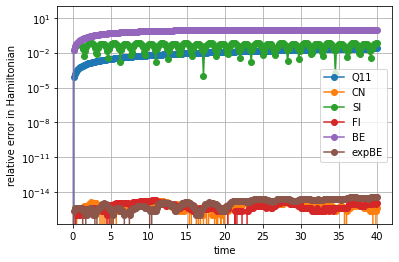

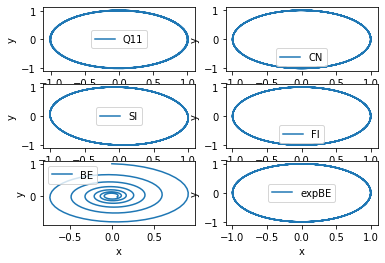

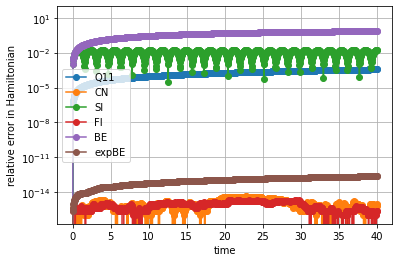

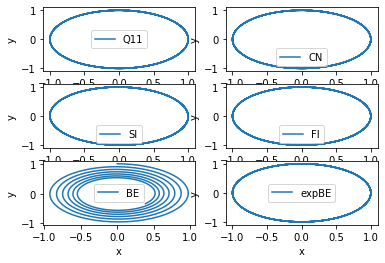

<Figure size 432x288 with 0 Axes>

In [11]:
res = testHamiltonian(2)

,h,Q11-error,Q11-eoc,CN-error,CN-eoc,SI-error,SI-eoc,FI-error,FI-eoc,BE-error,BE-eoc,expBE-error,expBE-eoc
0,6.6667e-03,4.920079e-01,nan,2.340031e-01,nan,2.516098e-01,nan,2.340031e-01,nan,9.964574e-01,nan,7.337768e-14,nan
1,3.3333e-03,1.191125e-01,2.046,5.909313e-02,1.985,9.588617e-02,1.392,5.909313e-02,1.985,9.309638e-01,0.098,1.000859e-13,-0.448
2,1.6667e-03,2.964800e-02,2.006,1.480481e-02,1.997,4.063059e-02,1.239,1.480481e-02,1.997,7.362502e-01,0.339,3.114512e-13,-1.638
3,8.3333e-04,7.407921e-03,2.001,3.703084e-03,1.999,1.848764e-02,1.136,3.703084e-03,1.999,4.865085e-01,0.598,7.556609e-13,-1.279
4,4.1667e-04,1.851863e-03,2.000,9.258873e-04,2.000,8.788152e-03,1.073,9.258873e-04,2.000,2.834529e-01,0.779,9.846553e-13,-0.382
5,2.0833e-04,4.629630e-04,2.000,2.314791e-04,2.000,4.280311e-03,1.038,2.314791e-04,2.000,1.535157e-01,0.885,1.634282e-12,-0.731
6,1.0417e-04,1.157407e-04,2.000,5.787022e-05,2.000,2.111746e-03,1.019,5.787020e-05,2.000,7.995523e-02,0.941,4.871898e-12,-1.576
7,5.2083e-05,2.893518e-05,2.000,1.446759e-05,2.000,1.048769e-03,1.010,1.446752e-05,2.000,4.081050e-02,0.970,1.200098e-11,-1.301
8,2.6042e-05,7.233812e-06,2.000,3.616882e-06,2.000,5.226089e-04,1.005,3.616748e-06,2.000,2.061781e-02,0.985,1.621878e-11,-0.435
9,1.3021e-05,1.808475e-06,2.000,9.041984e-07,2.000,2.608606e-04,1.002,9.038684e-07,2.001,1.036260e-02,0.993,2.698982e-11,-0.735


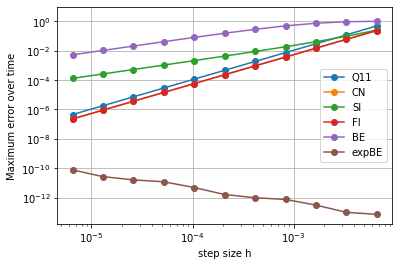

In [12]:
compareErrors(res)

Summary
-------
With the exception of the backward Euler method, the trajectories for all method look very similar with the semi-implicit method showing a slight tild in the axes of the ellise and for the larger h the Q11 showing some increase in the size of the ellipse over time - although one has to look closely to see that.

The convervation of the Hamiltonian over time is interesting showing as expected that the fully-implicit method conseves the Hamiltonian up to machine precission but the same is true for the Crank-Nicholson method. The three other method show a much larger error with the Q11 method increasing over time while the semi-implicit Euler method seems to keep the error constant which is what we expected from the discussion in Q1.3.

The Q11 method has about a factor of 2 higher error compared with CN are hardly. The CN and FI method are barely distinguishable. Therefore the Fully-Implicit method seems to be second order. The semi-implicit method first order outperforming the BE method by a factor of 50.

__Note__: the exponentially fit method was not part of assignment 2 so is not discussed here.

Tests with $r=4$ (Duffing equation)
-----------------------------------
Duffing equation see for example
https://www.cfm.brown.edu/people/dobrush/am34/Mathematica/ch3/duffing.html

/tmp/ipykernel_322270/3412270447.py:13: RuntimeWarning: overflow encountered in double_scalars
  dV  = lambda x: (k*k+1)*x      - k*k/2*r*x**(r-1)
/tmp/ipykernel_322270/3412270447.py:13: RuntimeWarning: invalid value encountered in double_scalars
  dV  = lambda x: (k*k+1)*x      - k*k/2*r*x**(r-1)
/tmp/ipykernel_322270/3412270447.py:12: RuntimeWarning: overflow encountered in double_scalars
  V   = lambda x: (k*k+1)/2*x**2 - k*k/2*x**r
/tmp/ipykernel_322270/3412270447.py:12: RuntimeWarning: invalid value encountered in double_scalars
  V   = lambda x: (k*k+1)/2*x**2 - k*k/2*x**r
/home/dedner/dunepy3.8-core/lib/python3.8/site-packages/numpy/linalg/linalg.py:2546: RuntimeWarning: overflow encountered in multiply
  s = (x.conj() * x).real
/media/nvme/OneDrive/MA261/assignments/assignment2/code/computeEocs.py:7: RuntimeWarning: divide by zero encountered in log
  eocs[i] = np.log(herr[i+1,1]/herr[i,1] ) /\


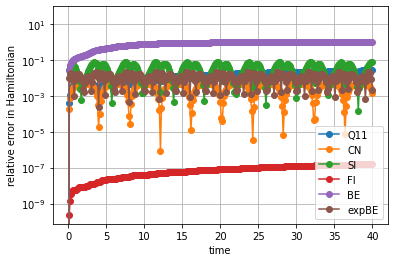

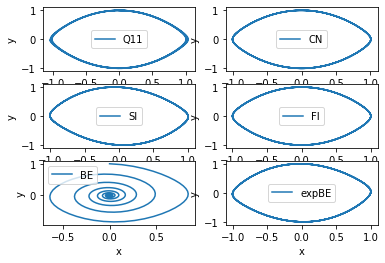

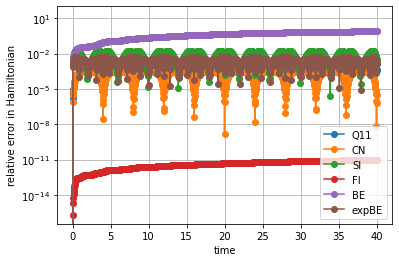

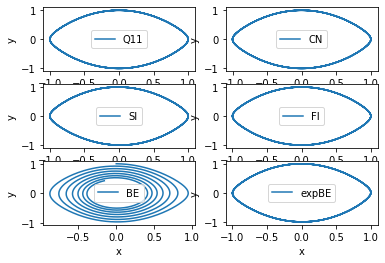

<Figure size 432x288 with 0 Axes>

In [13]:
res = testHamiltonian(4)

,h,Q11-error,Q11-eoc,CN-error,CN-eoc,SI-error,SI-eoc,FI-error,FI-eoc,BE-error,BE-eoc,expBE-error,expBE-eoc
0,6.6667e-03,inf,nan,1.671119e+00,nan,1.806380e+00,nan,1.321201e-01,nan,1.245470e+00,nan,2.806874e-01,nan
1,3.3333e-03,1.586126e+00,inf,5.155156e-01,1.697,5.503766e-01,1.715,3.303342e-02,2.000,1.391193e+00,-0.160,6.700920e-02,2.067
2,1.6667e-03,3.242903e-01,2.290,1.270692e-01,2.020,1.347051e-01,2.031,8.266157e-03,1.999,1.651777e+00,-0.248,2.702338e-02,1.310
3,8.3333e-04,5.871152e-02,2.466,3.153779e-02,2.010,3.330688e-02,2.016,2.067532e-03,1.999,1.777689e+00,-0.106,1.208117e-02,1.161
4,4.1667e-04,1.201850e-02,2.288,7.868168e-03,2.003,8.303854e-03,2.004,5.173182e-04,1.999,1.797906e+00,-0.016,5.686472e-03,1.087
5,2.0833e-04,2.677790e-03,2.166,1.965938e-03,2.001,2.971172e-03,1.483,1.292335e-04,2.001,1.865162e+00,-0.053,2.754922e-03,1.046
6,1.0417e-04,6.288112e-04,2.090,4.913843e-04,2.000,1.487067e-03,0.999,3.229364e-05,2.001,1.940380e+00,-0.057,1.355388e-03,1.023
7,5.2083e-05,1.521329e-04,2.047,1.228133e-04,2.000,7.439090e-04,0.999,8.077464e-06,1.999,1.535497e+00,0.338,6.721807e-04,1.012
8,2.6042e-05,3.739998e-05,2.024,3.067141e-05,2.001,3.720478e-04,1.000,2.016557e-06,2.002,1.013199e+00,0.600,3.347118e-04,1.006
9,1.3021e-05,9.270844e-06,2.012,7.644991e-06,2.004,1.860472e-04,1.000,5.091975e-07,1.986,5.788232e-01,0.808,1.670114e-04,1.003


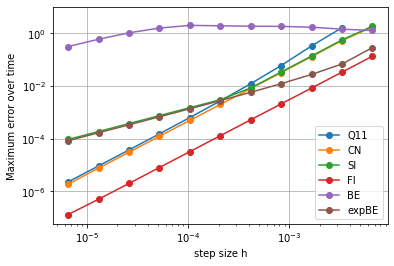

In [14]:
compareErrors(res)

Summary
-------
One main difference to before is that the CN method no longer conserve the Hamiltonian
while the fully-implict method does. Apparently CN does something special in the linear case of $r=2$.

The BE method again shows problems with the trajectory converging to zero. The error if this method is also higher than for the other methods only reaching an EOC close to the expected 1 for the mmallest time steps.

The SI method is again first order throughout and stable while the FI method is second order and keeps the Hamiltonian close to constant - the error possibly due to the stopping criteria of the Newton solver.
The approximation error is an order of magnitude smaller than the error produced by the other second order methods.

The Q11 method seems to have issues with stability for larger values of h but for smaller $h$ is once again very similar to the CN method.